<a href="https://colab.research.google.com/github/pragneshanekal/AutoML-Points-Predictor-Assignment/blob/main/AutoML_Player_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

This Python notebook employs the H2O AutoML library to evaluate various models' performance on the NBA dataset, which comprises 13 numerical and 8 categorical columns. Among these models, linear regression is selected for its interpretability and predictive accuracy in estimating the points scored by NBA players. Model assumptions including linearity, homoscedasticity, multicollinearity, autocorrelation, and normality of residuals are verified using residual plots. Relationships between predictor and response variables, as well as among independent variables, are examined to detect significant relationships and multicollinearity, respectively. Cross-validation is conducted exclusively on significant variables identified through Ordinary Least Squares (OLS) to achieve interpretable and accurate point predictions. L1 regularization is applied to penalize less significant variables and assess overfitting, along with exploring the impact of regularization on model predictions. The optimal alpha values are determined via cross-validation.

In [3]:
%pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=dd4c5b4e872a2fe31ccd745baadf1e931b3b9d4c37ed3cc81c4c2f3ba9a4e9ba
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [4]:
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from google.colab import drive
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2iwua1d5
  JVM stdout: /tmp/tmp2iwua1d5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2iwua1d5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_n6gsnc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Then adjust the path to where the file is located in your Google Drive
nba_data = h2o.import_file("/content/drive/My Drive/all_seasons.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
nba_data.types

{'C1': 'int',
 'player_name': 'enum',
 'team_abbreviation': 'enum',
 'age': 'int',
 'player_height': 'real',
 'player_weight': 'real',
 'college': 'enum',
 'country': 'enum',
 'draft_year': 'int',
 'draft_round': 'int',
 'draft_number': 'int',
 'gp': 'int',
 'pts': 'real',
 'reb': 'real',
 'ast': 'real',
 'net_rating': 'real',
 'oreb_pct': 'real',
 'dreb_pct': 'real',
 'usg_pct': 'real',
 'ts_pct': 'real',
 'ast_pct': 'real',
 'season': 'enum'}

In [9]:
nba_data = nba_data.drop('C1')

# Convert categorical columns to factors
categorical_columns = ['draft_year',
                       'draft_round', 'draft_number']
for col in categorical_columns:
    nba_data[col] = nba_data[col].asfactor()

# Verify the conversion
nba_data.types

{'player_name': 'enum',
 'team_abbreviation': 'enum',
 'age': 'int',
 'player_height': 'real',
 'player_weight': 'real',
 'college': 'enum',
 'country': 'enum',
 'draft_year': 'enum',
 'draft_round': 'enum',
 'draft_number': 'enum',
 'gp': 'int',
 'pts': 'real',
 'reb': 'real',
 'ast': 'real',
 'net_rating': 'real',
 'oreb_pct': 'real',
 'dreb_pct': 'real',
 'usg_pct': 'real',
 'ts_pct': 'real',
 'ast_pct': 'real',
 'season': 'enum'}

In [10]:
response = "pts"
predictors = list(nba_data.columns)
predictors.remove('pts')

In [11]:
aml = H2OAutoML(max_runtime_secs=600, seed=1, nfolds = 5)

In [12]:
aml.train(x=predictors, y=response, training_frame=nba_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/12
# GBM base models (used / total),2/5
# XGBoost base models (used / total),3/3
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [13]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20240219_171059,0.600233,0.36028,0.416894,nan,0.36028
StackedEnsemble_BestOfFamily_3_AutoML_1_20240219_171059,0.622559,0.38758,0.435924,nan,0.38758
DeepLearning_1_AutoML_1_20240219_171059,0.733295,0.537722,0.515064,nan,0.537722
StackedEnsemble_AllModels_1_AutoML_1_20240219_171059,0.748745,0.560619,0.522016,nan,0.560619
StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_171059,0.793968,0.630386,0.557164,nan,0.630386
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_171059,0.794397,0.631067,0.557435,nan,0.631067
XGBoost_3_AutoML_1_20240219_171059,0.870851,0.758381,0.63465,nan,0.758381
GBM_5_AutoML_1_20240219_171059,0.932669,0.869872,0.662325,nan,0.869872
GBM_1_AutoML_1_20240219_171059,0.936028,0.876147,0.665125,nan,0.876147
XGBoost_1_AutoML_1_20240219_171059,0.941606,0.886621,0.682504,nan,0.886621


Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


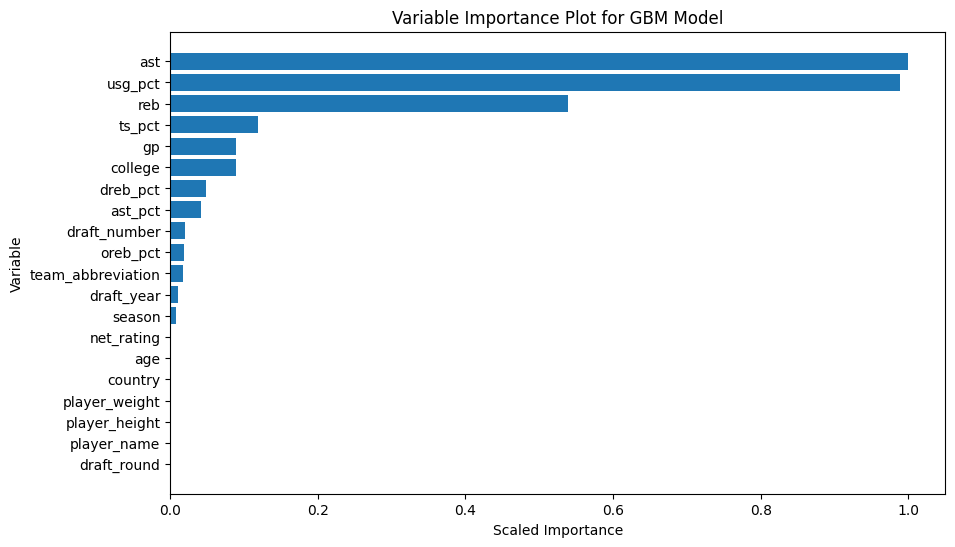

In [16]:
# Get the GBM Model from the leaderboard
model_row = aml.leaderboard.as_data_frame().iloc[6]

# Get model ID from the row
model_id = model_row['model_id']

# Retrieve the GBM model using the model ID
model = h2o.get_model(model_id)

# Retrieve the variable importance
varimp = model.varimp(use_pandas=True)

# Convert varimp dataframe to dictionary for plotting
varimp_dict = dict(zip(varimp['variable'], varimp['scaled_importance']))

# Sort variable importance dictionary by importance values
varimp_sorted = sorted(varimp_dict.items(), key=lambda x: x[1], reverse=True)

# Plot variable importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in varimp_sorted], [x[1] for x in varimp_sorted])
plt.xlabel('Scaled Importance')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for GBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to display variables with highest importance at the top
plt.show()

In [43]:
nba_df = pd.read_csv("/content/drive/My Drive/all_seasons.csv")

nba_df.drop(columns='Unnamed: 0', inplace=True)

In [44]:
# Convert all draft_number values to strings for uniform processing
nba_df['draft_number'] = nba_df['draft_number'].astype(str)

# Identify the maximum numerical draft number, excluding 'Undrafted'
max_draft_number = nba_df[nba_df['draft_number'] != 'Undrafted']['draft_number'].astype(int).max()

# Define a function to encode draft_number, treating 'Undrafted' as the lowest rank
def encode_draft_number(value):
    if value == 'Undrafted':
        return max_draft_number + 1 # Assign 'Undrafted' the highest numerical value to indicate the lowest rank
    else:
        return int(value) # Convert numerical draft positions to integers

# Apply the encoding function to the 'draft_number' column
nba_df['encoded_draft_number'] = nba_df['draft_number'].apply(encode_draft_number)

In [45]:
numeric_columns = ['age', 'player_height', 'player_weight', 'gp', 'reb', 'ast', 'net_rating',
                   'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'encoded_draft_number']

x = nba_df[numeric_columns]
y = nba_df['pts']

The top three predictors remain the same in both the significant p values (p < 0.05) and the variable importance rankings from the GBM model. However, their order may differ because variable importance emphasizes predictive importance, while p values show relationship significance.

In [32]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# Fit and transform to get the interaction terms
X_poly = poly.fit_transform(x)

feature_names = x.columns

# Get the feature names for the generated interaction terms
interaction_feature_names = poly.get_feature_names_out(feature_names)

# Now when you fit your model, you can create a DataFrame from the results
# and assign the feature names to the columns
interaction_terms_df = pd.DataFrame(X_poly, columns=interaction_feature_names)

# Proceed with your OLS model using 'interaction_terms_df' instead of 'X_poly'
X_train, X_test, y_train, y_test = train_test_split(interaction_terms_df, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)  # Add a constant to the model
model = sm.OLS(y_train, X_train_sm).fit()
p_values = model.pvalues

# Step 5: Sort p-values in ascending order
sorted_p_values = p_values.sort_values(ascending=True)

# Step 6: Display the significant p-values (i.e. p < 0.05)
significant_p_values = sorted_p_values[sorted_p_values < 0.05]

print(significant_p_values)

reb usg_pct                            0.000000e+00
ast usg_pct                            0.000000e+00
ast ast_pct                           1.339265e-235
gp usg_pct                            1.787470e-159
gp ast_pct                            2.489198e-105
                                          ...      
player_height encoded_draft_number     2.027616e-02
age dreb_pct                           2.821814e-02
age gp                                 2.997053e-02
net_rating usg_pct                     3.272765e-02
ts_pct                                 4.453420e-02
Length: 66, dtype: float64


In [46]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [47]:
# Intialize the linear regression model
model = LinearRegression()

#Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

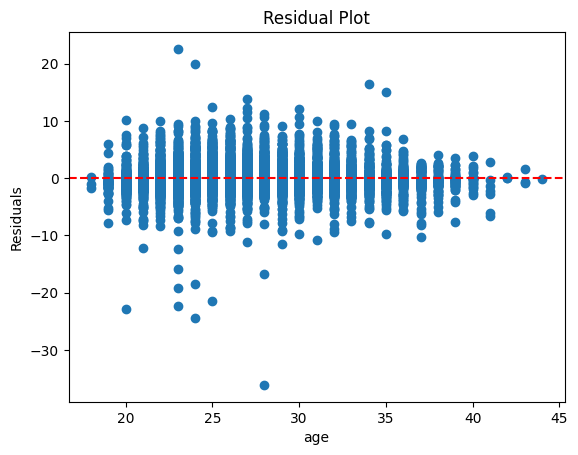

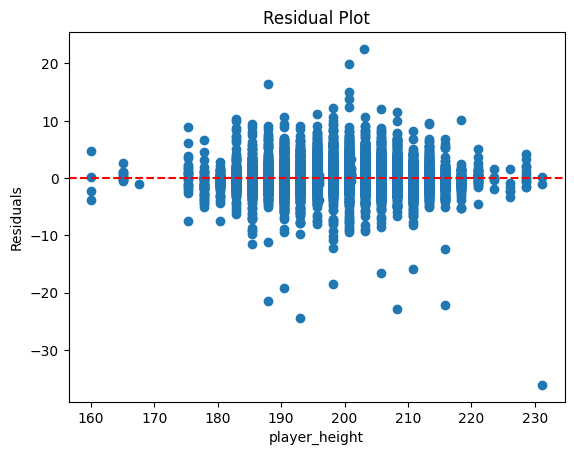

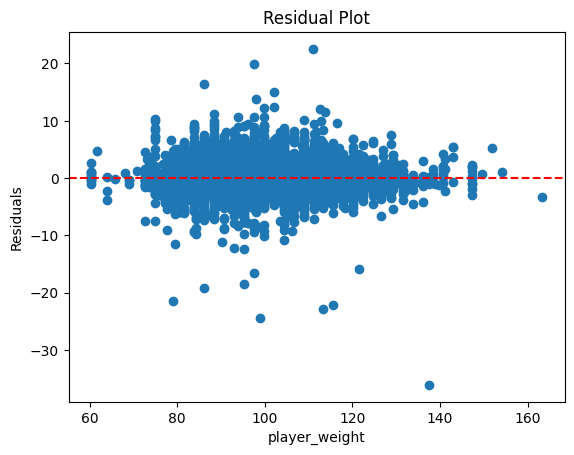

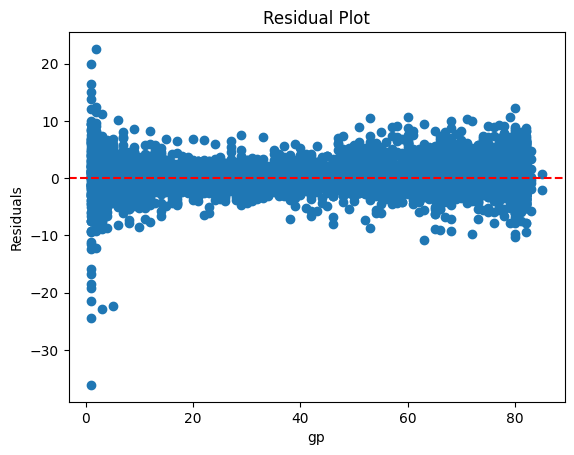

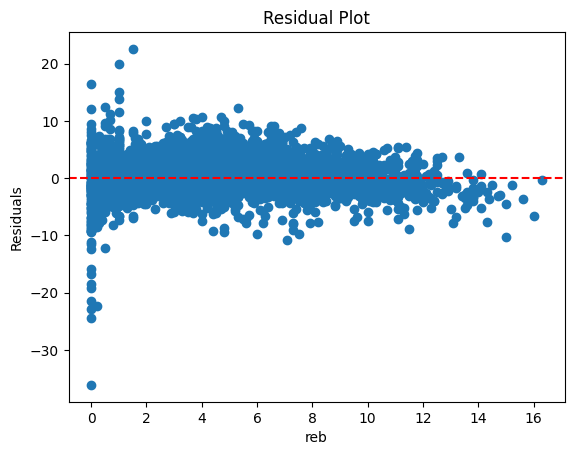

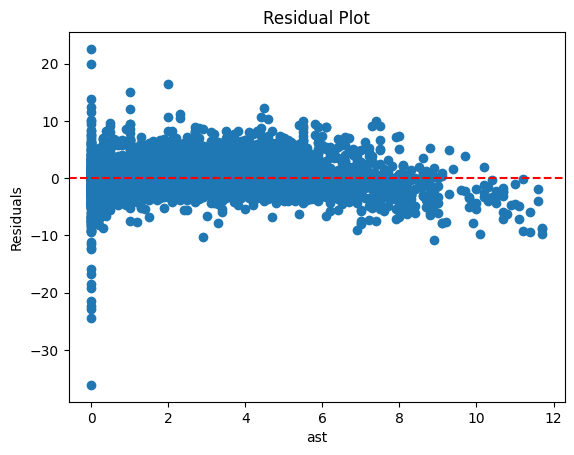

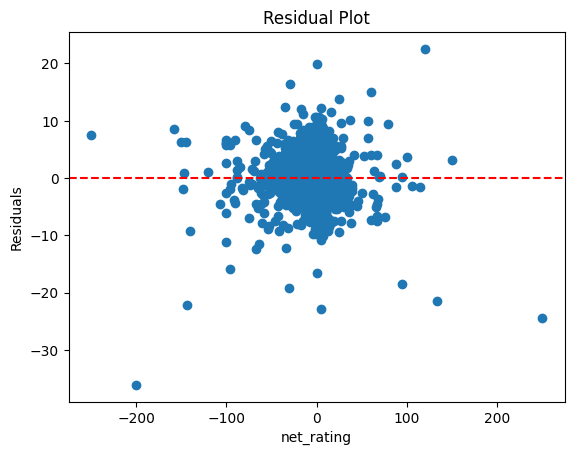

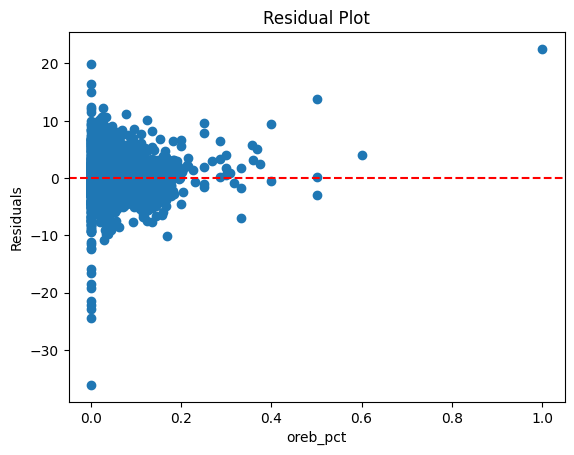

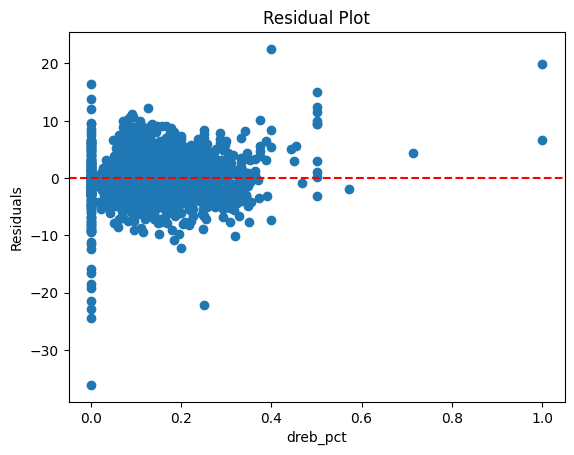

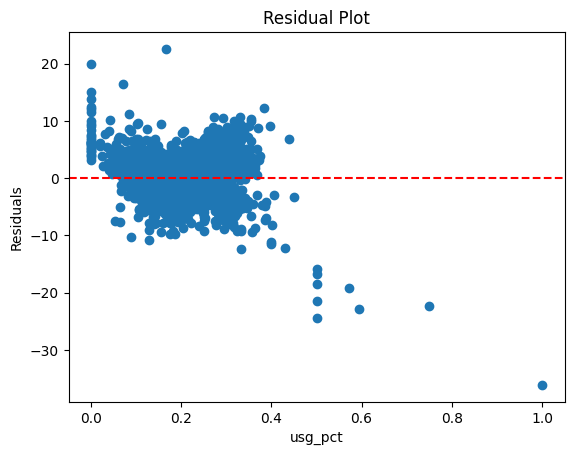

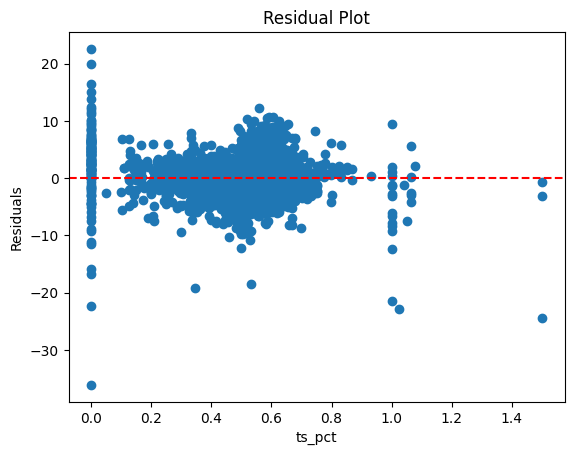

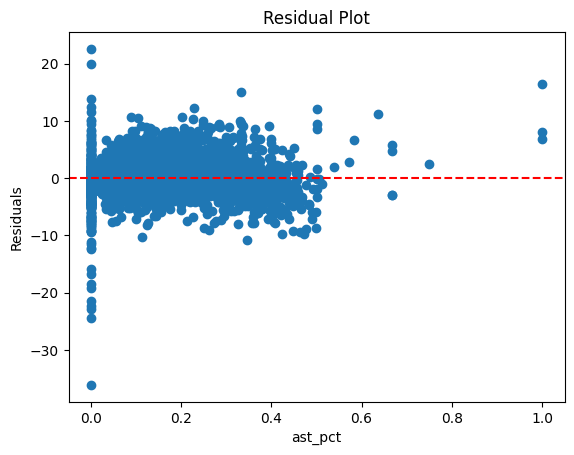

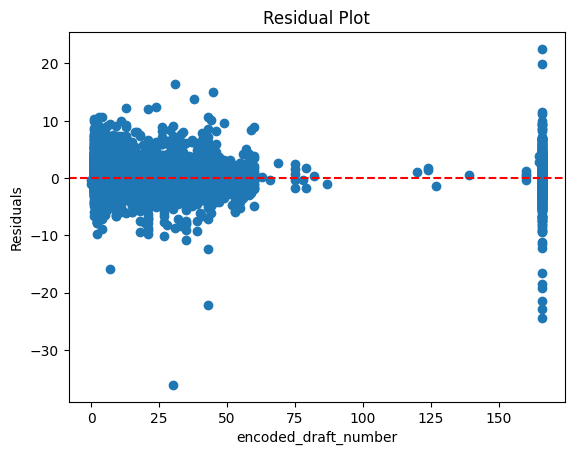

In [63]:
# Make predictions on the training data
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred

for column in X_train.columns:
  plt.scatter(X_train[column], residuals)
  plt.xlabel(column)
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='--')
  plt.show()

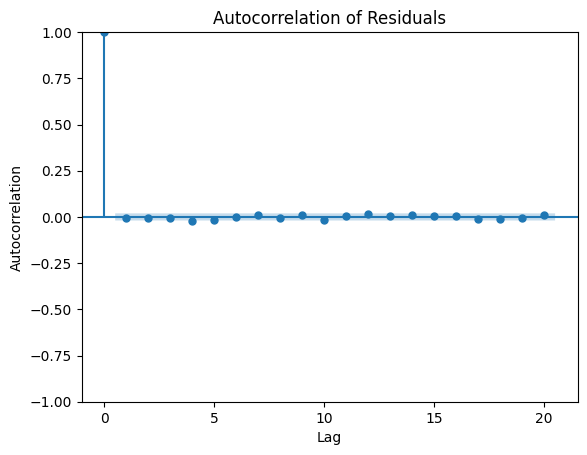

In [67]:
# Residuals Autocorrelation Plot
plot_acf(residuals, lags=20)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Residuals")
plt.show()

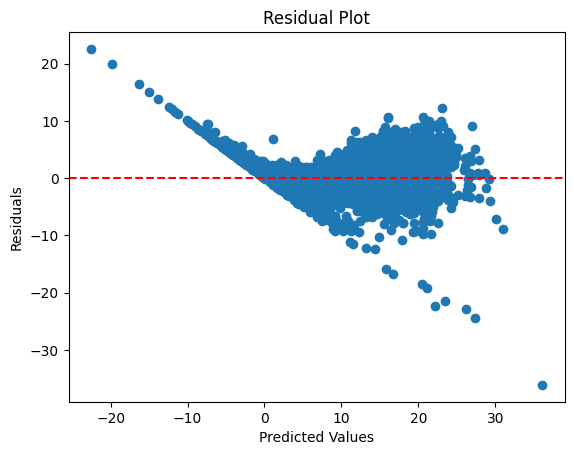

In [70]:
# Make predictions on the training data
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

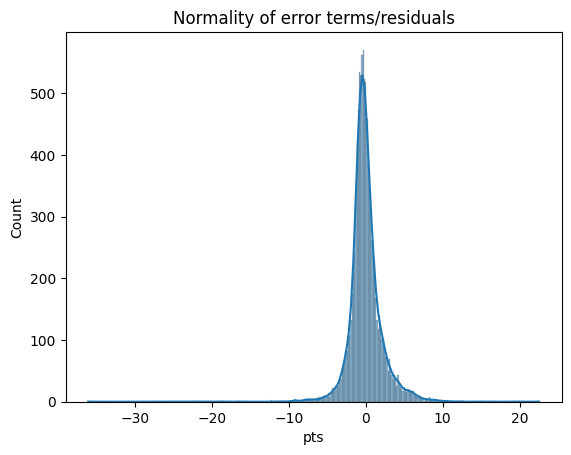

In [60]:
p = sns.histplot(residuals, kde=True)
p = plt.title('Normality of error terms/residuals')

In [71]:
nba_df.corr()

<ipython-input-71-ded3be66b2f5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nba_df.corr()


,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,encoded_draft_number
age,1.000000,-0.007904,0.063561,0.057442,0.011353,0.037386,0.092359,0.092896,-0.055228,0.018774,-0.113882,0.025245,0.069029,-0.014645
player_height,-0.007904,1.000000,0.822141,0.004963,-0.055284,0.424220,-0.442781,-0.003074,0.589538,0.614273,-0.104011,0.076797,-0.608696,-0.172858
player_weight,0.063561,0.822141,1.000000,0.022828,-0.025023,0.438112,-0.371675,0.003547,0.599511,0.605639,-0.065811,0.070992,-0.521939,-0.157239
gp,0.057442,0.004963,0.022828,1.000000,0.536003,0.471405,0.382726,0.248412,-0.014763,0.067911,0.147248,0.367876,0.131720,-0.316168
pts,0.011353,-0.055284,-0.025023,0.536003,1.000000,0.624509,0.664320,0.215199,-0.125164,0.055669,0.641469,0.373439,0.337339,-0.353981
reb,0.037386,0.424220,0.438112,0.471405,0.624509,1.000000,0.247841,0.187820,0.407960,0.611899,0.232968,0.313451,-0.062654,-0.318968
ast,0.092359,-0.442781,-0.371675,0.382726,0.664320,0.247841,1.000000,0.162865,-0.337970,-0.192146,0.396505,0.174494,0.803150,-0.209299
net_rating,0.092896,-0.003074,0.003547,0.248412,0.215199,0.187820,0.162865,1.000000,0.055761,0.047928,0.026575,0.313251,0.063809,-0.075508
oreb_pct,-0.055228,0.589538,0.599511,-0.014763,-0.125164,0.407960,-0.337970,0.055761,1.000000,0.555358,-0.100091,0.060572,-0.424056,-0.046604
dreb_pct,0.018774,0.614273,0.605639,0.067911,0.055669,0.611899,-0.192146,0.047928,0.555358,1.000000,-0.007402,0.105150,-0.317477,-0.131698


In [57]:
x = nba_df[numeric_columns]

# Define the number of folds
k_folds = 10  # You can adjust this number as needed

# Define the cross-validation strategy
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create a pipeline that first standardizes the data, then creates interaction terms,
# and finally applies a linear regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),               # Scale data
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),  # Generate interaction terms
    ('linear_regression', LinearRegression())   # Apply linear regression
])

In [59]:
# Define your scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform k-fold cross-validation
mse_scores = cross_val_score(pipeline, x, y, cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(pipeline, x, y, cv=kf, scoring='r2')

# Convert negative mean squared error scores to positive
mse_scores = -mse_scores

# Calculate the mean scores
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print("Mean Squared Error (Cross-validation):", mean_mse)
print("R-squared (Cross-validation):", mean_r2)

Mean Squared Error (Cross-validation): 0.7414684796468229
R-squared (Cross-validation): 0.9794799955734632


In [75]:
X = nba_df[numeric_columns]

# Target variable
y = nba_df['pts']

# Define the number of folds
k_folds = 10  # You can adjust this number as needed

# Define the cross-validation strategy
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Instantiate the Linear Regression model
model = LinearRegression()

# Perform k-fold cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Convert negative mean squared error scores to positive
mse_scores = -mse_scores

# Calculate the mean scores
mean_mse = mse_scores.mean()
mean_r2 = r2_scores.mean()

print("Mean Squared Error (Cross-validation):", mean_mse)
print("R-squared (Cross-validation):", mean_r2)

Mean Squared Error (Cross-validation): 4.629872240954284
R-squared (Cross-validation): 0.8719302581473786


In [86]:
# Define outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the test scores and MSEs for each alpha
test_scores = []
alpha_mse = []

# Define a wider range of alphas using logspace
alphas = np.logspace(-4, 0, 5)  # 5 values from 10^-4 to 10^0

# Outer cross-validation loop
for train_index, test_index in outer_cv.split(X):
    # Use .iloc for integer-location based indexing
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(alphas=alphas, cv=inner_cv)
    lasso_cv.fit(X_train_outer, y_train_outer)

    # Append the mean squared errors for this fold to the alpha_mse list
    mse_path = lasso_cv.mse_path_.mean(axis=1)  # Averaging over the folds
    alpha_mse.append(mse_path)

    # Train the model with the best hyperparameter on the outer training fold
    best_alpha = lasso_cv.alpha_
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train_outer, y_train_outer)

    # Evaluate the model on the outer test fold
    test_score = lasso.score(X_test_outer, y_test_outer)
    test_scores.append(test_score)

# Average the MSEs over all outer folds for each alpha
mean_mse_over_folds = np.mean(alpha_mse, axis=0)

# Create a DataFrame for easy analysis
alpha_scores = pd.DataFrame({
    'alpha': lasso_cv.alphas_,
    'mean_mse_over_folds': mean_mse_over_folds
})

# Sort the alphas by mean_mse_over_folds
alpha_scores_sorted = alpha_scores.sort_values(by='mean_mse_over_folds')

# Display the sorted alphas with their corresponding mean cross-validated scores
print(alpha_scores_sorted)

# Calculate and print the average test score
avg_test_score = np.mean(test_scores)
print("Average Test Score:", avg_test_score)

    alpha  mean_mse_over_folds
3  0.0010             4.641952
4  0.0001             4.642202
2  0.0100             4.842524
1  0.1000            11.164773
0  1.0000            11.786916
Average Test Score: 0.8719561767168363


# Conclusion

1. The AutoML algorithm ranks the Stacked Ensemble as the top-performing model for predicting points scored, as expected given its combination of various models with a meta learner, resulting in an MSE of 0.36.
2. Variable importance plots for the GBM model and calculated p-values from OLS for Linear regression reveal similar top variables in terms of significance and importance.
3. Despite the Stacked Ensemble's high ranking, Linear regression is chosen as the optimal model due to its interpretability and accuracy, especially after incorporating interaction terms.
4. Residual plots confirm the linearity assumption, with no discernible patterns between residuals and independent variables.
5. Normal distribution of residuals validates homoscedasticity, indicating consistent spread and justifying the use of OLS for coefficient determination.
6. A correlation matrix demonstrates no significant correlations among independent variables, indicating their independence from each other.
7. Autocorrelation plots exhibit autocorrelation values close to zero for all lag values, indicating no residual pattern correlation and effective capture of data patterns by the model.
8. K-fold cross-validation, incorporating interaction terms and significant variables determined by p-values, achieves an R2 score of 0.97, ensuring both accuracy and interpretability.
9. L1 regularization analysis suggests minimal impact on model performance, indicating no evidence of overfitting. Various alpha values are tested, but no signs of overfitting are observed.
10. Optimal alpha values are determined through cross-validation, further solidifying the model's robustness and performance.

**Question 1: Is the relationship significant?**

Yes, the relationship between the predictor variables and the response variable is deemed significant based on both AutoML rankings, variable importance analysis and p values obtained through OLS.

**Question 2: Are any model assumptions violated?**

No, model assumptions such as linearity, homoscedasticity, and independence of residuals are not violated, as confirmed by residual plots, distribution analysis, and autocorrelation plots, respectively.

**Question 3: Is there any multicollinearity in the model?**

No multicollinearity is observed among the predictor variables, as evidenced by the correlation matrix indicating no significant correlations among them.

**Question 4: In the multivariate models are predictor variables independent of all the other predictor variables?**

Yes, in multivariate models, the predictor variables demonstrate independence from each other, as indicated by the lack of significant correlations in the correlation matrix.

**Question 5: In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

Significant predictor variables are determined through p-values from OLS, allowing for the exclusion of insignificant variables from the model, thus enhancing its interpretability and accuracy. Interaction terms are also considered to improve model accuracy.

**Question 6: Does the model make sense?**

Yes, the chosen Linear regression model makes sense given its simplicity, interpretability, and accuracy (R square of 0.97), especially when incorporating interaction terms.

**Question 7: Does regularization help?**

Regularization does not substantially impact model performance, as observed through L1 regularization analysis, suggesting no evidence of overfitting.

**Question 8: Which independent variables are significant?**

Significant independent variables are identified through p-values from OLS (p < 0.05), guiding the selection of predictors in the model.

**Question 9:  Which hyperparameters are important?**

Important hyperparameters, such as alpha values for regularization, are determined through cross-validation, ensuring optimal model performance and robustness.